## Import thư viện

In [7]:
import torch
from torch import nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchsummary
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import time
import json
import os
from datasets import load_dataset
import pandas as pd
from PIL import Image

## Model

In [8]:
# For Resnet34 and below

class BuildingBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BuildingBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)       
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(x)
        out = self.relu(out)
        return out

In [9]:
# For Resnet50 and above

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super(Bottleneck, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)       
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += self.shortcut(x)
        out = self.relu(out)
        return out
        

In [10]:
class Resnet(nn.Module):
    def __init__(self, block, num_blocks, kernel_size=7, stride=2, padding=3, num_classes=1000):
        super(Resnet, self).__init__()

        self.in_channels = 64

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) #ImageNet

        self.conv2_x = self.make_layer(block, 64, num_blocks[0])
        self.conv3_x = self.make_layer(block, 128, num_blocks[1], stride=2)
        self.conv4_x = self.make_layer(block, 256, num_blocks[2], stride=2)
        self.conv5_x = self.make_layer(block, 512, num_blocks[3], stride=2) #ImageNet

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def make_layer(self, block, out_channels, num_blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = block.expansion * out_channels
        for idx in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x) #ImageNet

        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.conv4_x(x)
        x = self.conv5_x(x) #ImageNet

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [11]:
class Resnet18(Resnet):
    def __init__(self, kernel_size, stride, padding, num_classes):
        super().__init__(
            block=BuildingBlock,
            num_blocks=[2, 2, 2, 2],
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            num_classes=num_classes
        )

class Resnet34(Resnet):
    def __init__(self, kernel_size, stride, padding, num_classes):
        super().__init__(
            block=BuildingBlock,
            num_blocks=[3, 4, 6, 3],
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            num_classes=num_classes
        )

class Resnet50(Resnet):
    def __init__(self, kernel_size, stride, padding, num_classes):
        super().__init__(
            block=Bottleneck,
            num_blocks=[3, 4, 6, 3],
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            num_classes=num_classes
        )

class Resnet101(Resnet):
    def __init__(self, kernel_size, stride, padding, num_classes):
        super().__init__(
            block=Bottleneck,
            num_blocks=[3, 4, 23, 3],
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            num_classes=num_classes
        )

class Resnet152(Resnet):
    def __init__(self, kernel_size, stride, padding, num_classes):
        super().__init__(
            block=Bottleneck,
            num_blocks=[3, 8, 36, 3],
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            num_classes=num_classes
        )

In [12]:
model = Resnet18(kernel_size=3, stride=1, padding=1, num_classes=200)
torchsummary.summary(model)
x = torch.randn(5, 3, 64, 64)
out = model(x)
out.shape

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            1,728
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─BuildingBlock: 2-1                --
|    |    └─Conv2d: 3-1                  36,864
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  36,864
|    |    └─BatchNorm2d: 3-5             128
|    |    └─Sequential: 3-6              --
|    └─BuildingBlock: 2-2                --
|    |    └─Conv2d: 3-7                  36,864
|    |    └─BatchNorm2d: 3-8             128
|    |    └─ReLU: 3-9                    --
|    |    └─Conv2d: 3-10                 36,864
|    |    └─BatchNorm2d: 3-11            128
|    |    └─Sequential: 3-12             --
├─Sequential: 1-6                        --
|    └─BuildingBlock: 2-3                --
|  

torch.Size([5, 200])

## TinyImageNet

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Prepare data

In [8]:
class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.image_dir = os.path.join(root_dir, 'train')
        self.classes = sorted(os.listdir(self.image_dir))
        self.images = []
        self.labels = []

        if split == 'train':
            for label_idx, class_dir in enumerate(self.classes):
                class_images = os.listdir(os.path.join(self.image_dir, class_dir, 'images'))
                for img_name in class_images:
                    img_path = os.path.join(self.image_dir, class_dir, 'images', img_name)
                    if self.is_rgb(img_path):
                        self.images.append(os.path.join(class_dir, 'images', img_name))
                        self.labels.append(label_idx)

        elif split == 'val':
            self.image_dir = os.path.join(root_dir, 'val', 'images')
            self.annotations_file = os.path.join(root_dir, 'val', 'val_annotations.txt')
            annotations = pd.read_csv(self.annotations_file, sep='\t', header=None)
            for img_name, label in zip(annotations[0], annotations[1]):
                img_path = os.path.join(self.image_dir, img_name)
                if self.is_rgb(img_path):
                    self.images.append(img_name)
                    self.labels.append(self.classes.index(label))

    def is_rgb(self, img_path):
        with Image.open(img_path) as img:
            return img.mode == 'RGB'

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.images[idx])
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]

        return image, label


In [10]:
transform_train = transforms.Compose([
    transforms.RandomCrop(64, padding=4),  
    transforms.RandomHorizontalFlip(),    
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) 
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

trainset = TinyImageNetDataset(root_dir='tiny-imagenet-200', split='train', transform=transform_train)
testset = TinyImageNetDataset(root_dir='tiny-imagenet-200', split='val', transform=transform_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


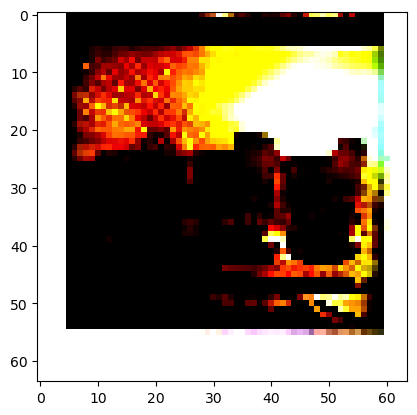

In [11]:
image = testset[2][0].permute(1, 2, 0).numpy()

plt.imshow(image)

In [12]:
print(f'Size: {image.shape}')
print(f'Train: {len(trainset)}')
print(f'Test: {len(testset)}')
print(f'Classes: {len(testset.classes)}')

Size: (64, 64, 3)
Train: 98179
Test: 9832
Classes: 200


### Config

In [13]:
checkpoint_id = 1
folder_path = f'./Resnet/TinyImageNet/checkpoint{checkpoint_id}/'
kernel_size = 5
stride = 1
padding = 2
num_classes = len(trainset.classes)
batch_size = 256
num_epochs = 100
learning_rate = 0.001
step_size = 50

os.makedirs(folder_path, exist_ok=True)

config = {
    "checkpoint_id": checkpoint_id,
    "folder_path": folder_path,
    "model": 'Resnet34',
    "kernel_size": kernel_size,
    "stride": stride,
    "padding": padding,
    "num_classes": num_classes,
    "batch_size": batch_size,
    "num_epochs": num_epochs,
    "learning_rate": learning_rate,
    "step_size": step_size
}

with open(folder_path + "config.json", "w") as f:
    json.dump(config, f, indent=4)

In [14]:
model = Resnet18(kernel_size, stride, padding, num_classes).to(device)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)
print(model)

Resnet18(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2_x): Sequential(
    (0): BuildingBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BuildingBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

### Train, test

In [15]:
def train(model, trainloader, criterion, optimizer, scheduler, device, folder_path, num_epochs=10):
    model.train()
    epoch_losses = []
    start = time.time()
    for epoch in tqdm(range(num_epochs)):
        running_loss = 0
        for i, (inputs, labels) in enumerate(trainloader, 0):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad() 

            outputs = model(inputs) 
            loss = criterion(outputs, labels)  
            loss.backward()
            optimizer.step() 

            running_loss += loss.item()
        running_loss = running_loss / len(trainloader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}')
        epoch_losses.append(running_loss)
        scheduler.step()
    end = time.time()
    training_time = (end - start) / 3600

    plt.plot(range(1, num_epochs + 1), epoch_losses)
    plt.title('Training Loss per Epoch')
    plt.suptitle(f'Training time: {training_time:.2f} hours')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig(folder_path + 'training_loss.png')
    plt.show()

    torch.save(model.state_dict(), folder_path + 'model_weights.pth')

def evaluate(model, testloader, device, folder_path):
    model.eval()
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    correct = sum([1 for a, p in zip(all_labels, all_predictions) if a == p])
    total = len(all_labels)
    accuracy = 100 * correct / total
    report = classification_report(all_labels, all_predictions)
    print(f'Accuracy: {accuracy:.2f}%')
    print("Classification Report:")
    print(report)

    with open(folder_path + 'report.txt', "w") as f:
        f.write(f'Accuracy: {accuracy:.2f}%\n')
        f.write("Classification Report:\n\n")
        f.write(report)
    

  1%|          | 1/100 [03:01<4:59:35, 181.57s/it]

Epoch [1/100], Loss: 4.3044


  2%|▏         | 2/100 [05:51<4:45:50, 175.01s/it]

Epoch [2/100], Loss: 3.5529


  3%|▎         | 3/100 [08:42<4:39:51, 173.11s/it]

Epoch [3/100], Loss: 3.2211


  4%|▍         | 4/100 [11:37<4:37:56, 173.72s/it]

Epoch [4/100], Loss: 2.9943


  5%|▌         | 5/100 [14:28<4:33:45, 172.90s/it]

Epoch [5/100], Loss: 2.8082


  6%|▌         | 6/100 [17:19<4:29:26, 171.98s/it]

Epoch [6/100], Loss: 2.6502


  7%|▋         | 7/100 [20:11<4:26:51, 172.17s/it]

Epoch [7/100], Loss: 2.5180


  8%|▊         | 8/100 [23:04<4:24:20, 172.40s/it]

Epoch [8/100], Loss: 2.4073


  9%|▉         | 9/100 [25:56<4:21:12, 172.22s/it]

Epoch [9/100], Loss: 2.3189


 10%|█         | 10/100 [28:49<4:18:41, 172.46s/it]

Epoch [10/100], Loss: 2.2358


 11%|█         | 11/100 [31:39<4:14:32, 171.60s/it]

Epoch [11/100], Loss: 2.1687


 12%|█▏        | 12/100 [34:31<4:12:01, 171.83s/it]

Epoch [12/100], Loss: 2.1078


 13%|█▎        | 13/100 [37:23<4:09:06, 171.80s/it]

Epoch [13/100], Loss: 2.0525


 14%|█▍        | 14/100 [40:14<4:05:59, 171.62s/it]

Epoch [14/100], Loss: 2.0069


 15%|█▌        | 15/100 [43:06<4:03:18, 171.75s/it]

Epoch [15/100], Loss: 1.9597


 16%|█▌        | 16/100 [45:59<4:00:55, 172.09s/it]

Epoch [16/100], Loss: 1.9207


 17%|█▋        | 17/100 [48:52<3:58:25, 172.35s/it]

Epoch [17/100], Loss: 1.8884


 18%|█▊        | 18/100 [51:44<3:55:20, 172.20s/it]

Epoch [18/100], Loss: 1.8548


 19%|█▉        | 19/100 [54:34<3:51:48, 171.72s/it]

Epoch [19/100], Loss: 1.8198


 20%|██        | 20/100 [57:26<3:49:07, 171.85s/it]

Epoch [20/100], Loss: 1.7967


 21%|██        | 21/100 [1:00:18<3:46:12, 171.80s/it]

Epoch [21/100], Loss: 1.7721


 22%|██▏       | 22/100 [1:03:10<3:43:30, 171.94s/it]

Epoch [22/100], Loss: 1.7483


 23%|██▎       | 23/100 [1:06:00<3:39:37, 171.13s/it]

Epoch [23/100], Loss: 1.7230


 24%|██▍       | 24/100 [1:08:50<3:36:36, 171.01s/it]

Epoch [24/100], Loss: 1.7052


 25%|██▌       | 25/100 [1:11:42<3:33:54, 171.12s/it]

Epoch [25/100], Loss: 1.6901


 26%|██▌       | 26/100 [1:14:34<3:31:27, 171.45s/it]

Epoch [26/100], Loss: 1.6720


 27%|██▋       | 27/100 [1:17:20<3:26:35, 169.80s/it]

Epoch [27/100], Loss: 1.6535


 28%|██▊       | 28/100 [1:20:12<3:24:38, 170.54s/it]

Epoch [28/100], Loss: 1.6378


 29%|██▉       | 29/100 [1:23:04<3:22:25, 171.07s/it]

Epoch [29/100], Loss: 1.6219


 30%|███       | 30/100 [1:25:57<3:20:00, 171.44s/it]

Epoch [30/100], Loss: 1.6095


 31%|███       | 31/100 [1:28:48<3:17:08, 171.43s/it]

Epoch [31/100], Loss: 1.5961


 32%|███▏      | 32/100 [1:31:39<3:14:02, 171.21s/it]

Epoch [32/100], Loss: 1.5808


 33%|███▎      | 33/100 [1:34:23<3:08:51, 169.12s/it]

Epoch [33/100], Loss: 1.5654


 34%|███▍      | 34/100 [1:37:16<3:07:08, 170.14s/it]

Epoch [34/100], Loss: 1.5558


 35%|███▌      | 35/100 [1:40:01<3:02:45, 168.70s/it]

Epoch [35/100], Loss: 1.5469


 36%|███▌      | 36/100 [1:42:45<2:58:23, 167.25s/it]

Epoch [36/100], Loss: 1.5326


 37%|███▋      | 37/100 [1:45:33<2:56:02, 167.66s/it]

Epoch [37/100], Loss: 1.5256


 38%|███▊      | 38/100 [1:48:17<2:52:07, 166.58s/it]

Epoch [38/100], Loss: 1.5148


 39%|███▉      | 39/100 [1:51:01<2:48:29, 165.74s/it]

Epoch [39/100], Loss: 1.5044


 40%|████      | 40/100 [1:53:47<2:45:47, 165.78s/it]

Epoch [40/100], Loss: 1.4971


 41%|████      | 41/100 [1:56:39<2:44:44, 167.53s/it]

Epoch [41/100], Loss: 1.4859


 42%|████▏     | 42/100 [1:59:30<2:43:07, 168.75s/it]

Epoch [42/100], Loss: 1.4798


 43%|████▎     | 43/100 [2:02:23<2:41:28, 169.97s/it]

Epoch [43/100], Loss: 1.4775


 44%|████▍     | 44/100 [2:05:14<2:38:50, 170.18s/it]

Epoch [44/100], Loss: 1.4635


 45%|████▌     | 45/100 [2:08:05<2:36:14, 170.45s/it]

Epoch [45/100], Loss: 1.4586


 46%|████▌     | 46/100 [2:10:57<2:33:53, 170.99s/it]

Epoch [46/100], Loss: 1.4506


 47%|████▋     | 47/100 [2:13:51<2:31:45, 171.80s/it]

Epoch [47/100], Loss: 1.4386


 48%|████▊     | 48/100 [2:16:41<2:28:27, 171.31s/it]

Epoch [48/100], Loss: 1.4425


 49%|████▉     | 49/100 [2:19:33<2:25:42, 171.43s/it]

Epoch [49/100], Loss: 1.4285


 50%|█████     | 50/100 [2:22:26<2:23:16, 171.94s/it]

Epoch [50/100], Loss: 1.4235


 51%|█████     | 51/100 [2:25:17<2:20:08, 171.60s/it]

Epoch [51/100], Loss: 1.0732


 52%|█████▏    | 52/100 [2:28:06<2:16:45, 170.94s/it]

Epoch [52/100], Loss: 0.9508


 53%|█████▎    | 53/100 [2:30:56<2:13:46, 170.77s/it]

Epoch [53/100], Loss: 0.8925


 54%|█████▍    | 54/100 [2:33:47<2:10:53, 170.73s/it]

Epoch [54/100], Loss: 0.8506


 55%|█████▌    | 55/100 [2:36:39<2:08:23, 171.19s/it]

Epoch [55/100], Loss: 0.8127


 56%|█████▌    | 56/100 [2:39:31<2:05:36, 171.28s/it]

Epoch [56/100], Loss: 0.7812


 57%|█████▋    | 57/100 [2:42:24<2:03:04, 171.72s/it]

Epoch [57/100], Loss: 0.7556


 58%|█████▊    | 58/100 [2:45:17<2:00:30, 172.16s/it]

Epoch [58/100], Loss: 0.7263


 59%|█████▉    | 59/100 [2:48:10<1:57:53, 172.53s/it]

Epoch [59/100], Loss: 0.7031


 60%|██████    | 60/100 [2:51:01<1:54:46, 172.16s/it]

Epoch [60/100], Loss: 0.6801


 61%|██████    | 61/100 [2:53:53<1:51:45, 171.94s/it]

Epoch [61/100], Loss: 0.6576


 62%|██████▏   | 62/100 [2:56:46<1:49:05, 172.25s/it]

Epoch [62/100], Loss: 0.6354


 63%|██████▎   | 63/100 [2:59:35<1:45:41, 171.39s/it]

Epoch [63/100], Loss: 0.6181


 64%|██████▍   | 64/100 [3:02:27<1:42:52, 171.46s/it]

Epoch [64/100], Loss: 0.5996


 65%|██████▌   | 65/100 [3:05:20<1:40:14, 171.84s/it]

Epoch [65/100], Loss: 0.5817


 66%|██████▌   | 66/100 [3:08:12<1:37:29, 172.05s/it]

Epoch [66/100], Loss: 0.5641


 67%|██████▋   | 67/100 [3:11:03<1:34:22, 171.59s/it]

Epoch [67/100], Loss: 0.5474


 68%|██████▊   | 68/100 [3:13:56<1:31:46, 172.08s/it]

Epoch [68/100], Loss: 0.5331


 69%|██████▉   | 69/100 [3:16:48<1:28:54, 172.08s/it]

Epoch [69/100], Loss: 0.5185


 70%|███████   | 70/100 [3:19:41<1:26:12, 172.40s/it]

Epoch [70/100], Loss: 0.5037


 71%|███████   | 71/100 [3:22:35<1:23:32, 172.84s/it]

Epoch [71/100], Loss: 0.4906


 72%|███████▏  | 72/100 [3:25:26<1:20:24, 172.29s/it]

Epoch [72/100], Loss: 0.4787


 73%|███████▎  | 73/100 [3:28:17<1:17:21, 171.90s/it]

Epoch [73/100], Loss: 0.4656


 74%|███████▍  | 74/100 [3:31:07<1:14:18, 171.47s/it]

Epoch [74/100], Loss: 0.4519


 75%|███████▌  | 75/100 [3:33:59<1:11:30, 171.62s/it]

Epoch [75/100], Loss: 0.4439


 76%|███████▌  | 76/100 [3:36:49<1:08:27, 171.17s/it]

Epoch [76/100], Loss: 0.4299


 77%|███████▋  | 77/100 [3:39:42<1:05:44, 171.49s/it]

Epoch [77/100], Loss: 0.4196


 78%|███████▊  | 78/100 [3:42:34<1:02:55, 171.59s/it]

Epoch [78/100], Loss: 0.4097


 79%|███████▉  | 79/100 [3:45:25<1:00:03, 171.59s/it]

Epoch [79/100], Loss: 0.3991


 80%|████████  | 80/100 [3:48:17<57:13, 171.67s/it]  

Epoch [80/100], Loss: 0.3899


 81%|████████  | 81/100 [3:51:10<54:27, 171.99s/it]

Epoch [81/100], Loss: 0.3817


 82%|████████▏ | 82/100 [3:54:01<51:34, 171.93s/it]

Epoch [82/100], Loss: 0.3692


 83%|████████▎ | 83/100 [3:56:52<48:33, 171.39s/it]

Epoch [83/100], Loss: 0.3641


 84%|████████▍ | 84/100 [3:59:45<45:51, 171.96s/it]

Epoch [84/100], Loss: 0.3569


 85%|████████▌ | 85/100 [4:02:30<42:28, 169.91s/it]

Epoch [85/100], Loss: 0.3511


 86%|████████▌ | 86/100 [4:05:26<40:04, 171.75s/it]

Epoch [86/100], Loss: 0.3401


 87%|████████▋ | 87/100 [4:08:11<36:45, 169.66s/it]

Epoch [87/100], Loss: 0.3341


 88%|████████▊ | 88/100 [4:11:03<34:05, 170.43s/it]

Epoch [88/100], Loss: 0.3273


 89%|████████▉ | 89/100 [4:13:54<31:17, 170.70s/it]

Epoch [89/100], Loss: 0.3186


 90%|█████████ | 90/100 [4:16:38<28:04, 168.43s/it]

Epoch [90/100], Loss: 0.3134


 91%|█████████ | 91/100 [4:19:23<25:06, 167.43s/it]

Epoch [91/100], Loss: 0.3120


 92%|█████████▏| 92/100 [4:22:07<22:12, 166.51s/it]

Epoch [92/100], Loss: 0.3013


 93%|█████████▎| 93/100 [4:24:51<19:19, 165.71s/it]

Epoch [93/100], Loss: 0.2937


 94%|█████████▍| 94/100 [4:27:41<16:42, 167.04s/it]

Epoch [94/100], Loss: 0.2909


 95%|█████████▌| 95/100 [4:30:33<14:01, 168.38s/it]

Epoch [95/100], Loss: 0.2848


 96%|█████████▌| 96/100 [4:33:23<11:15, 168.91s/it]

Epoch [96/100], Loss: 0.2825


 97%|█████████▋| 97/100 [4:36:15<08:29, 169.81s/it]

Epoch [97/100], Loss: 0.2800


 98%|█████████▊| 98/100 [4:39:06<05:40, 170.23s/it]

Epoch [98/100], Loss: 0.2751


 99%|█████████▉| 99/100 [4:41:57<02:50, 170.60s/it]

Epoch [99/100], Loss: 0.2676


100%|██████████| 100/100 [4:44:48<00:00, 170.88s/it]

Epoch [100/100], Loss: 0.2685


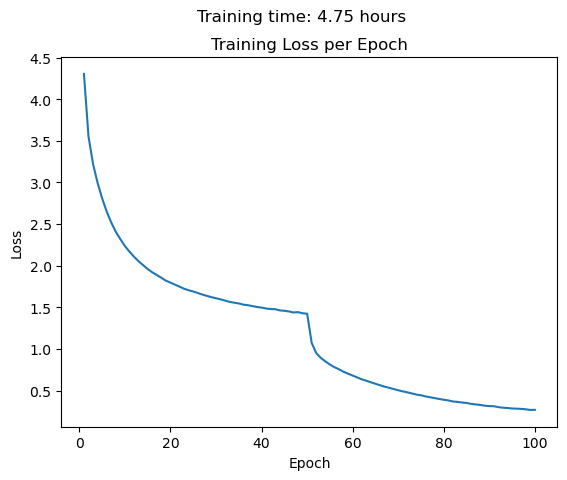

In [16]:
train(model, trainloader, criterion, optimizer, scheduler, device, folder_path, num_epochs=num_epochs)

In [17]:
evaluate(model, testloader, device, folder_path)

Accuracy: 54.78%
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.86        50
           1       0.76      0.74      0.75        50
           2       0.60      0.72      0.65        50
           3       0.45      0.36      0.40        50
           4       0.56      0.51      0.53        49
           5       0.38      0.36      0.37        50
           6       0.84      0.76      0.80        50
           7       0.53      0.52      0.53        50
           8       0.68      0.76      0.72        50
           9       0.66      0.58      0.62        50
          10       0.52      0.56      0.54        50
          11       0.55      0.60      0.57        47
          12       0.67      0.68      0.67        50
          13       0.73      0.70      0.71        50
          14       0.74      0.52      0.61        50
          15       0.50      0.43      0.46        49
          16       0.34      0.29      0.